<a href="https://colab.research.google.com/github/JamesPeralta/Gymnos/blob/master/Neural-Network/Iteration2/Model_Training_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gymnos Iteration 2
## Gymnos iteration 2 will use a single stream 2D convolutional neural network. For each video we will be passing in only one frame and the AIs prediction will be based on the single frame.



In [0]:
# You can list all of the hardware device running on your instance
from tensorflow.python.client import device_lib

local_devices = device_lib.list_local_devices()

for device in local_devices:
  print("_______________________________________\n" + str(device))

---
## Uploading all custom modules into the Instance

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 21.8MB/s 


In [0]:
# Upload the DataGenerator Module
data_generator_id = '1lKl35Vj_HAtNFUpTDU4je4-XtwaTrvHM'
gymnos_DataGenerator = drive.CreateFile({'id': data_generator_id})
gymnos_DataGenerator.GetContentFile('GymnoDataGenerator_i2.py')

# Upload the HelperFunctions Module
helper_functions_id = '1GG3x8YHPy6UGcdWj2kLQ0BHBgKhaZ1iQ'
helper_functions = drive.CreateFile({'id': helper_functions_id})
helper_functions.GetContentFile('HelperFunctions_i2.py')

In [4]:
from google.colab import drive
import os
import csv

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


---
## Imports

In [5]:
import GymnoDataGenerator_i2 as gen
import HelperFunctions_i2 as helper

Using TensorFlow backend.


---
## Create a labels and partitions CSV


In [0]:
csv_location = "/content/drive/My Drive/GYMNOS/Video Dataset/"
labels_location = "/content/drive/My Drive/GYMNOS/Video Dataset/labels.csv"
partitions_location = "/content/drive/My Drive/GYMNOS/Video Dataset/partitions.csv"
squats_location = "/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/"
overhead_location = "/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/"
squats_label = 0
overhead_label = 1

In [0]:
helper.init_labels_csv(labels_location)

In [0]:
# Label the squat dataset
helper.append_to_labels_csv(labels_location, squats_location, squats_label)

# Label the overhead press dataset
helper.append_to_labels_csv(labels_location, overhead_location, overhead_label)

In [12]:
helper.generate_partitions_csv(partitions_location, labels_location)

53
15
8


---
## Read in the labels and partitions CSVs


In [0]:
partition_location = "/content/drive/My Drive/GYMNOS/Video Dataset/partitions.csv"
labels_location = "/content/drive/My Drive/GYMNOS/Video Dataset/labels.csv"

partition = helper.read_partition_csv(partition_location)
labels = helper.read_labels_csv(labels_location)

In [7]:
print(len(partition["train"]))
print(len(partition["validation"]))
print(len(partition["test"]))

53
15
8


In [0]:
# Expand the train partition by 20
new_train = []
for i in range(20):
  for train in partition["train"]:
    new_train.append(train)
    
partition["train"] = new_train

In [9]:
print(partition["train"])

['/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/video16.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/IMG_8986.TRIM.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/IMG_8689 (1).TRIM.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/IMG_8988.TRIM.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/video20.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/IMG_8688.TRIM.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/video15.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/video21.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/video26.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/IMG_8983.TRIM.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/video4.MOV', '/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/video27.MOV', '/cont

--- 
## Initialize the DataGenerator

In [0]:
import matplotlib.pyplot as plt

In [0]:
train_params = {'frames_per_video': 15,
                'frame_dim': (256, 256),
                'batch_size': 1,
                'n_classes': 2,
                'shuffle': True}

train_generator = gen.DataGenerator(partition["train"], labels, **train_params)

In [12]:
test_vids = partition["train"]
test_vids[0]

'/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/video16.MOV'

In [13]:
vid_frames = train_generator.extract_frames_from_directory(test_vids[0])

NameError: ignored

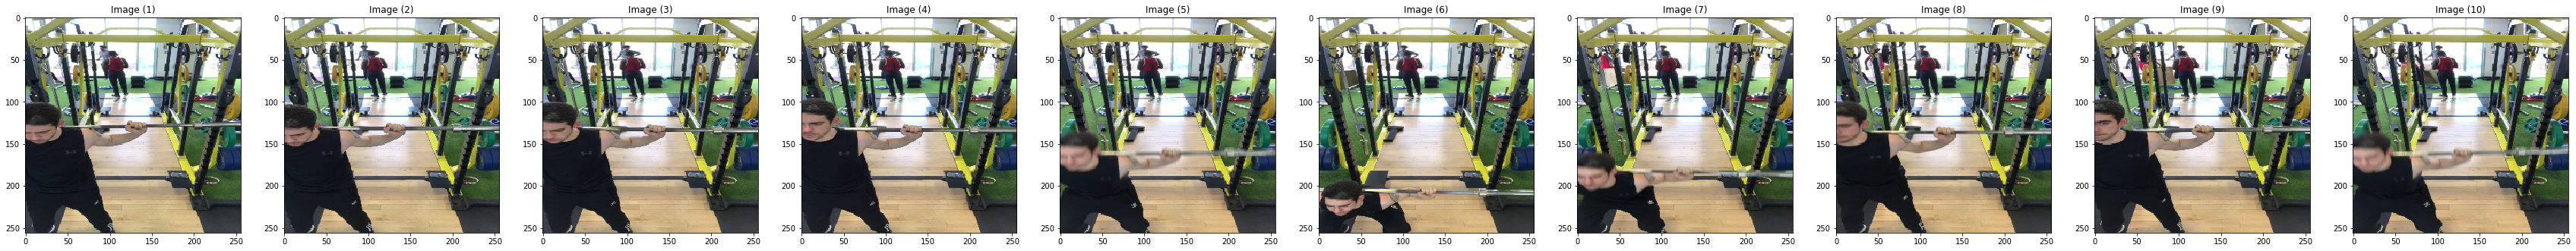

In [41]:
helper.show_images(vid_frames)

In [42]:
vid_frames.shape

(10, 256, 256, 3)

In [0]:
import cv2
import numpy as np
from random import randint

def extract_frames_test(source):
  """
  Extracts frames from a video

  Parameters
  ---------
  source: The video we would like to retrieve frames from

  Returns
  ---------
  video_frames: Frames from the video that was passed in
  """
  destination = "/content/drive/My Drive/GYMNOS/Video Dataset/Frames/"
  video_frames = []
  cap = cv2.VideoCapture(source)  # capturing the video from the given path
  length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print(length)
  pos = randint(0, length - 140)
  cap.set(1, pos);
  
  frames_to_extract = 10
  frame_dim = (256, 256)

  # Pull franes from videos until we have reached the amount we want to extract
  while (cap.isOpened() and len(video_frames) < frames_to_extract):
    frame_id = cap.get(1)  # current frame number
    ret, frame = cap.read()
    if (ret != True):
      break

    # We are capturing at 28 frames per second.
    # If we want to capture every 0.2 seconds we will take every 5 frames
    if (frame_id % 14 == 0):
      filename ="frame%d.jpg" % frame_id
      resized = cv2.resize(frame, frame_dim) # Reads as BGR
      destRGB = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB) # Convert to RGB
      video_frames.append(np.rot90(destRGB, 3)) # Rotate the image to an upright position

  cap.release()
  return np.array(video_frames)

---
## Add TPU Support

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.train import RMSPropOptimizer
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import load_model

---
## Create the model


In [0]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))    # include_top=False to remove the top layer

# Freeze all of the layers from the Conv base because we are performing transfer learning on
for layer in base_model.layers:
  layer.trainable = False
  
for layer in base_model.layers:
  print(layer, layer.trainable)

In [0]:
model = Sequential()

model.add(base_model)

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 25,693,186
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# Convert model to TPU version
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
            model,
            strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

INFO:tensorflow:Querying Tensorflow master (grpc://10.124.2.114:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 14033533245884826474)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17619780622966036123)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 10525561790330708032)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 13538007211903003179)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 12541477285445433208)
INFO:tensorflow:*** Available Device: _DeviceAttribut

In [0]:
tpu_model.compile(optimizer=RMSPropOptimizer(learning_rate=1e-3), 
              loss=binary_crossentropy,
              metrics=['acc'])

In [0]:
train_generator.__len__()

In [0]:
history = tpu_model.fit_generator(train_generator,
                                  steps_per_epoch=train_generator.__len__(),
                                  epochs=30,
                                  validation_data=validation_generator,
                                  validation_steps=validation_generator.__len__(),
                                  verbose=1)

Epoch 1/30
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(8,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(8, 224, 224, 3), dtype=tf.float32, name='vgg16_input_30'), TensorSpec(shape=(8, 2), dtype=tf.float32, name='dense_3_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for vgg16_input
INFO:tensorflow:Remapping placeholder for input_2
INFO:tensorflow:Default: input_2
ERROR:tensorflow:Operation of type Placeholder (tpu_139642142791664/input_2) is not supported on the TPU. Execution will fail if this op is used in the graph. 
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling


RuntimeError: ignored

In [0]:
iteration_1_location = "/content/drive/My Drive/GYMNOS/Software Development/Implementation Details/Gymnos_i1/gymnos_i1_GPU.h5"

In [0]:
# Save all of your hard work
model.save(iteration_1_location)

---
## Evaluating the Model
Now that the Model has it's weights initialized, let see how it performs on the test set.

In [0]:
trained_model = load_model(iteration_1_location)

In [0]:
# Parameters
params = {'data_location': "/content/drive/My Drive/GYMNOS/Video Dataset/Frames/",
          'dim': (224, 224, 3),
          'batch_size': 64,
          'n_classes': 2,
          'shuffle': True}

test_generator = gen.DataGenerator(partition["test"], labels, **params)

In [0]:
images, pred_class = test_generator.__getitem__(0)

In [0]:
helper.show_images(images)

In [0]:
model_predictions = trained_model.predict_classes(images)

In [0]:
for index, number in enumerate(model_predictions):
  if number == 0:
    print("Image("+ str(index + 1) + ") is a squat")
  else:
    print("Image("+ str(index + 1) + ") is a overheadpress")